# Visión por Computadora 2025
#           Lab 1
### Juan Luis Solórzano carnet: 201598
### Diego Alonzo - 20172

In [1]:
# !pip freeze > requirements.txt

In [1]:
import numpy as np
from extras import*
import matplotlib.pyplot as plt
import skimage as ski
from PIL import Image
from scipy.ndimage import uniform_filter

riz = plt.imread('walk.jpg')
riz = ski.color.rgb2gray(riz[:,:,:3])

riz = (riz*255).astype(np.uint8)
riz.shape


(1621, 2369)


### 1. Ecualización de histograma

Implementar en Python una función que haga la ecualización de histograma para una imagen en escala de grises (8 bits). 

- Mostrar la imagen original y la imagen ecualizada.
- Mostrar también los histogramas normalizados y su distribución acumulada de ambas imágenes.
- Comparar los resultados de su función contra alguna función ya predefinida en Python (por ejemplo, `skimage.exposure.equalize_hist` o `cv2.equalizeHist`).
- Explicar las diferencias o similitudes entre ambas implementaciones.




In [3]:
def ecualizar(Im):
    L, C = Im.shape  #dimencion foto
    n = L * C  # pixeles de la foto
    
    # comando histograma de la foto
    f, b = np.histogram(Im, bins=256, range=(0, 255))
    b = np.round(b).astype(np.uint8)
    # Normalizar 
    fn = f / n  
    
    # Calcular la función de distribución acumulativa (CDF)
    Fn = np.cumsum(fn)
    
    fe = np.zeros(256)
    #algorithmo de ecualisación
    be = np.round(Fn * 255).astype(np.uint8)
    s = 0 
    mem = -1
    j = 0
    for i in be:
        if mem != i:
            s = Fn[i]
            fe[i] = fn[j]
            mem = i
        
        j +=1
    Fe = np.cumsum(fe)        
    # Aplicar la transformación a la imagen
    I = Im.copy()
    for i in range(L):
        for j in range(C):
            I[i, j] = be[Im[i, j]]
    v0 = (Im, b[:256],fn,Fn)
    v1 = (I,b[:256],fe,Fe)
    
    return v0,v1  # Devolver la imagen ecualizada (I), la original (IM) con sus distribuciones. acumuladas
oF, eF = ecualizar(riz)
Ie = ski.exposure.equalize_hist(riz, nbins=256, mask=None)
Ie = (Ie * 255).astype(np.uint8)

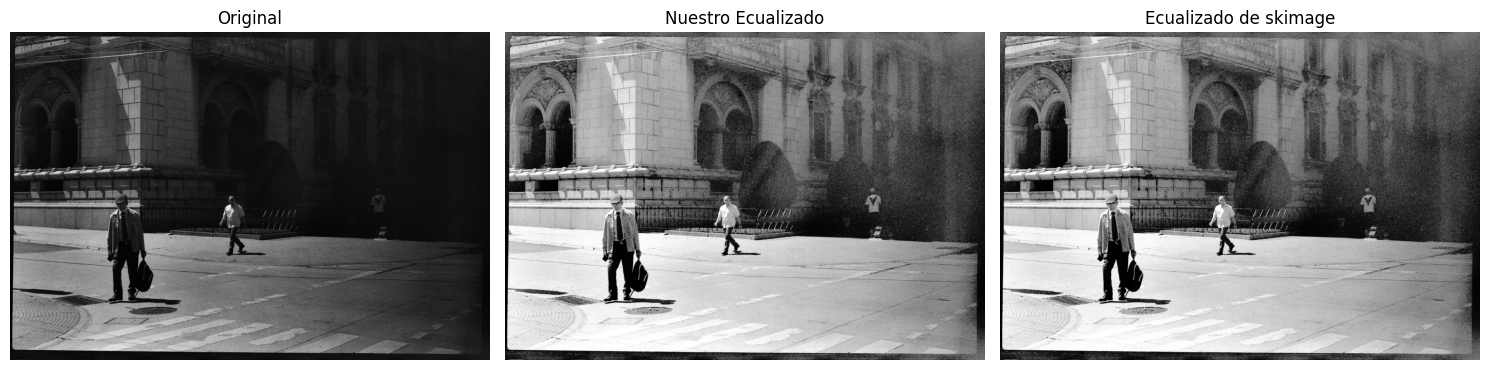

In [4]:
 mostrar_imagenes(['Original', 'Nuestro Ecualizado', 'Ecualizado de skimage'],[oF[0], eF[0], Ie])

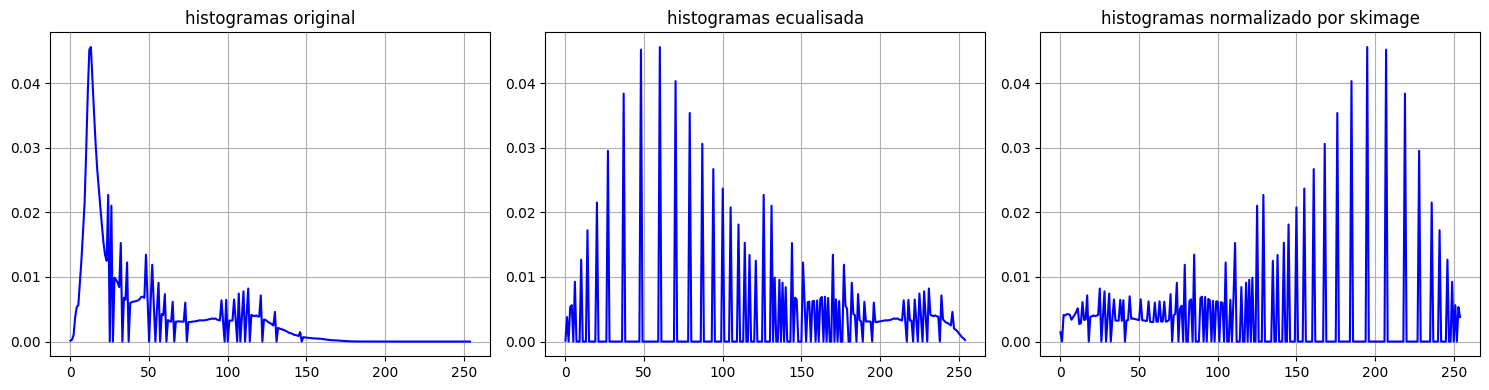

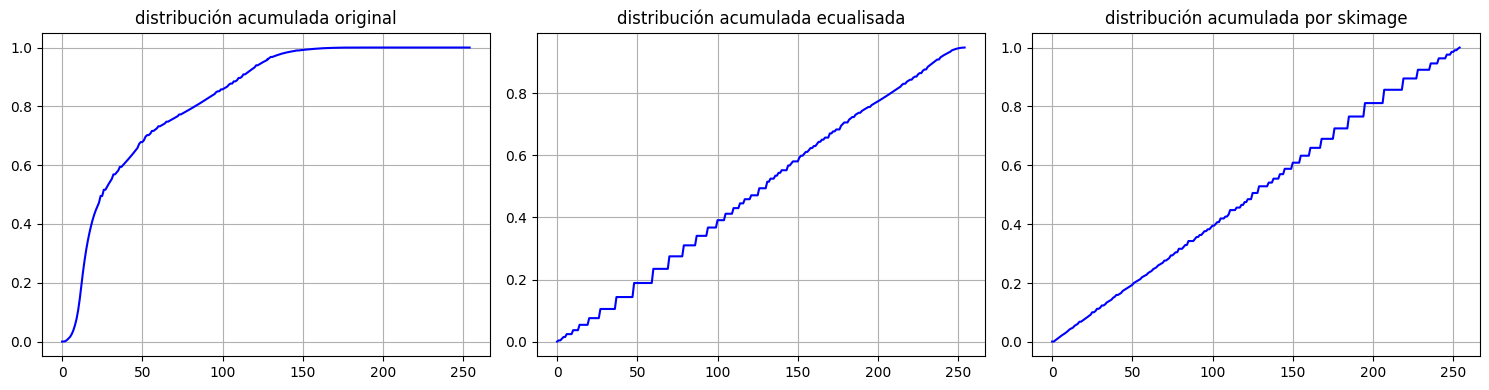

In [5]:
Ie = (Ie * 255).astype(np.uint8)
f , x = np.histogram(Ie, bins=256, range=(0, 255))
x = np.round(x).astype(np.uint8)
L, C = Ie.shape
f = f/ (C*L)
F = np.cumsum(f)
datos = [(oF[1],oF[2]),(eF[1],eF[2]),(oF[1],f)]
titulos = ['histogramas original','histogramas ecualisada','histogramas normalizado por skimage']
mostrar_graficas(datos, titulos)
datos = [(oF[1],oF[3]),(eF[1],eF[3]),(oF[1],F)]
titulos = ['distribución acumulada original','distribución acumulada ecualisada','distribución acumulada por skimage']
mostrar_graficas(datos, titulos)


### 2. Segmentación binaria de imágenes

Implementar 3 algoritmos para segmentación binaria de imágenes. Uno de estos debe ser un algoritmo local.

- Aplicar cada algoritmo a al menos 3 imágenes en escala de grises.
- Comparar los resultados obtenidos visualmente.
- Concluir cuál de los algoritmos obtiene mejores resultados.



In [2]:
riz = plt.imread('rice.jpg')
riz = ski.color.rgb2gray(riz[:,:,:3])

riz = (riz*255).astype(np.uint8)

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def Th(I, t):
    I = I.copy()  
    I[I < t] = 0
    I[I >= t] = 255
    return I

def ThRC(I, t=123):
    if t <= I.min() or t >= I.max():
        t = np.mean([I.min(), I.max()])  # Corregido el cálculo de t inicial

    tm = t + 1
    i = 0
    while abs(tm - t) > 1e-6 and i < 9:  # Corregida la condición de parada
        B = I[I < t]
        F = I[I > t]
        
        # Evitar división por cero si B o F están vacíos
        mB = np.mean(B) if B.size > 0 else 0
        mF = np.mean(F) if F.size > 0 else 255
        
        tm = t
        t = (mB + mF) / 2
        i += 1

    return Th(I, t), t, i  # Asegurar que se devuelve la imagen binarizada

def ThLocal(I, h, w):
    h //= 2
    w //= 2
    H, W = I.shape
    Th = np.full((H, W), 100, dtype=np.uint8)  
    I2 = np.zeros((H, W), dtype=np.uint8)

    for i in range(H):
        for j in range(W):
            i_min, i_max = max(0, i - h), min(H, i + h + 1)
            j_min, j_max = max(0, j - w), min(W, j + w + 1)
            
            Iw = I[i_min:i_max, j_min:j_max]

            if Iw.size == 0:
                continue

            _, Th[i, j], _ = ThRC(Iw)  # Corregido para ignorar la imagen binarizada
            I2[i, j] = 255 if I[i, j] > Th[i, j] else 0  # Corregido el umbral binario

    return I2, Th

# Cargar imagen de prueba (asegurar que `riz` está definido como imagen en escala de grises)
#riz = np.random.randint(0, 256, (100, 100), dtype=np.uint8)  # Ejemplo de imagen aleatoria



In [21]:

    
def ThSauvola(I,w = 12 , k= 0.5, R=128):
    I = I.astype(np.float32)
    
    mu = uniform_filter(I, w, mode='reflect')
    
    mu_sq = uniform_filter(I**2, w, mode='reflect')
    s = np.sqrt(mu_sq - mu**2)

    Th = mu * (1 + k * ((s / R) - 1))
    return (I> Th).astype(np.uint8)*255, Th
    

In [15]:


I01, t, i = ThRC(riz)
print('i=', i)
print('t=', t)

I02, Th = ThLocal(riz, 30,250)

I03 , Th2 = ThSauvola(riz,50,.00001,500)

i= 4
t= 130.76466224305193


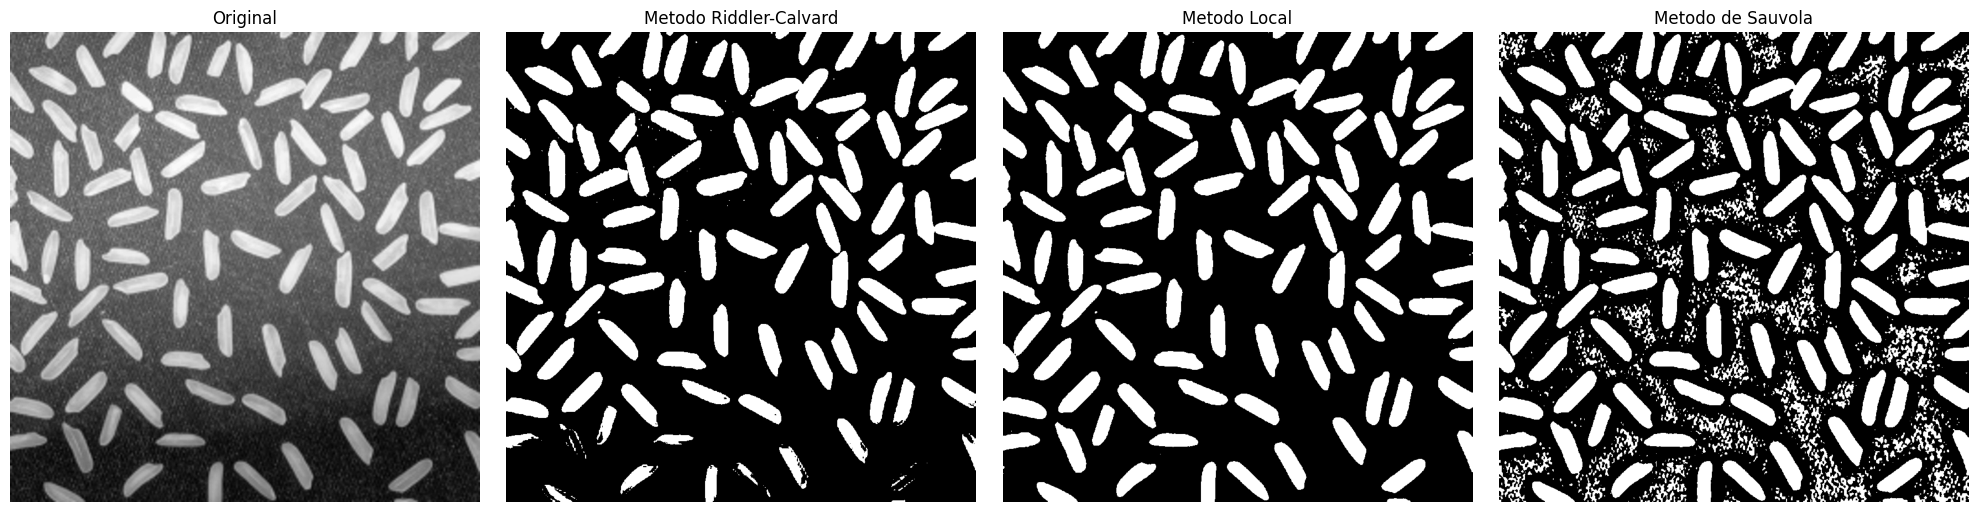

In [16]:
mostrar_imagenes(['Original','Metodo Riddler-Calvard', 'Metodo Local', 'Metodo de Sauvola'],[riz,I01, I02, I03])

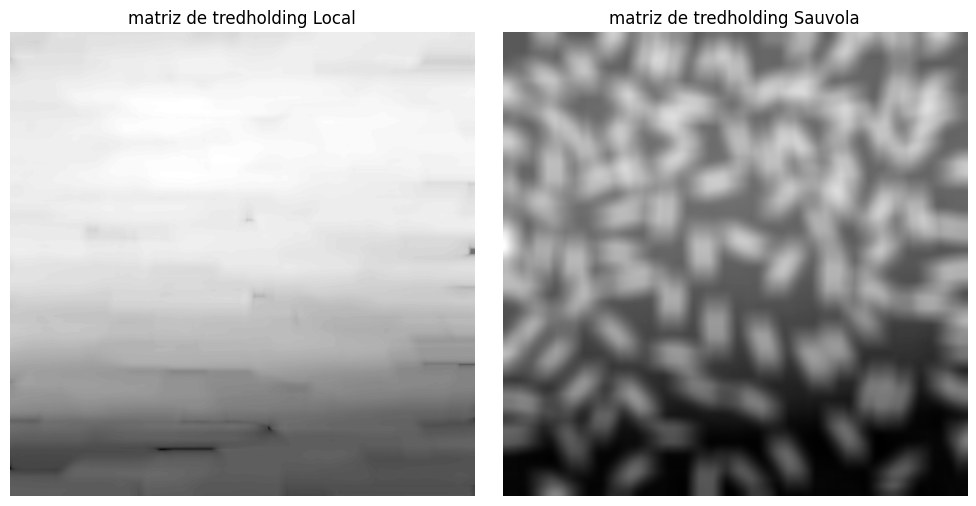

In [17]:
mostrar_imagenes(['matriz de tredholding Local','matriz de tredholding Sauvola'],[Th,Th2])

i= 3
t= 120.55278880376169


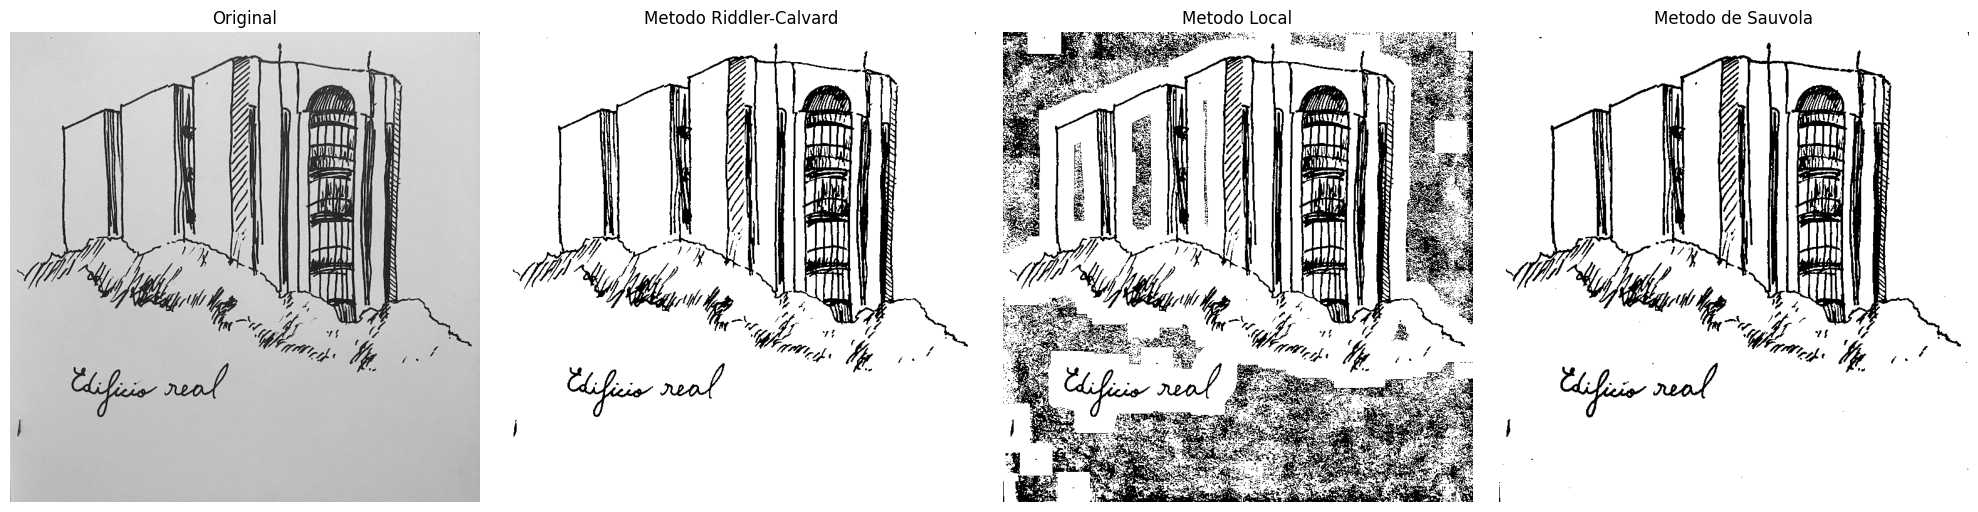

In [29]:
riz = plt.imread('Edificio.jpg')
riz = ski.color.rgb2gray(riz[:,:,:3])

riz = (riz*255).astype(np.uint8)

I11, t, i = ThRC(riz)
print('i=', i)
print('t=', t)

I12, Th1 = ThLocal(riz, 50,50)

I13 , Th12 = ThSauvola(riz,50,.1,200)
mostrar_imagenes(['Original','Metodo Riddler-Calvard', 'Metodo Local', 'Metodo de Sauvola'],[riz,I11, I12, I13])

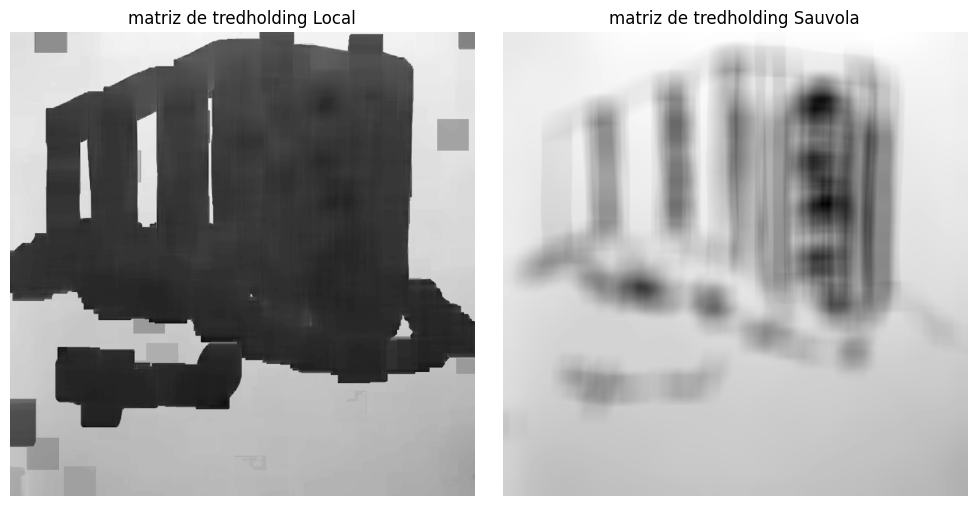

In [31]:
mostrar_imagenes(['matriz de tredholding Local','matriz de tredholding Sauvola'],[Th1,Th12])

i= 6
t= 100.5150077811441


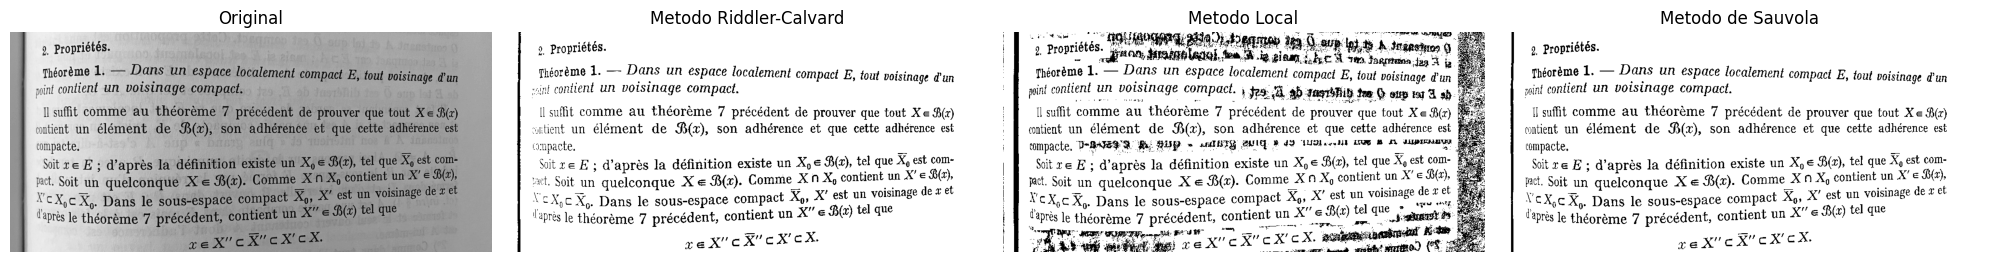

In [33]:
riz = plt.imread('teorema.jpg')
riz = ski.color.rgb2gray(riz[:,:,:3])

riz = (riz*255).astype(np.uint8)

I21, t, i = ThRC(riz)
print('i=', i)
print('t=', t)

I22, Th1 = ThLocal(riz, 30,30)

I23 , Th12 = ThSauvola(riz,30,.5,150)
mostrar_imagenes(['Original','Metodo Riddler-Calvard', 'Metodo Local', 'Metodo de Sauvola'],[riz,I21, I22, I23])

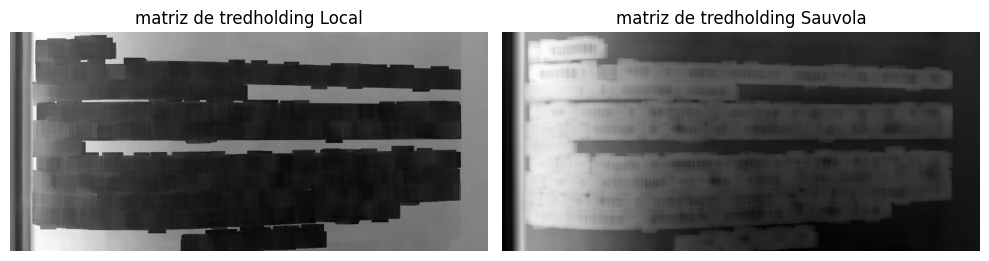

In [34]:
mostrar_imagenes(['matriz de tredholding Local','matriz de tredholding Sauvola'],[Th1,Th12])

### 3. Segmentación en imágenes RGB con k-medias

Implementar un algoritmo de segmentación para imágenes RGB utilizando el algoritmo de k-medias.

- Permitir al usuario elegir el parámetro k (k ≥ 2).
- Mostrar ejemplos de segmentación con:
  - Imagen original.
  - Mapa de segmentos o clases.
  - Imagen cuantizada (promedio de color en cada segmento).
- Presentar al menos dos ejemplos buenos y dos malos, explicando sus alcances y limitaciones.



### 4. Análisis de cromaticidad

- Convertir las imágenes `coca-cola.jpeg` y `pepsi.png` de RGB a un espacio de color cromático adecuado.
- Elaborar el histograma del canal de cromaticidad.
- Analizar el histograma y concluir qué ocurre con los colores en cada imagen.



### 5. Segmentación binaria de granos de arroz

- Implementar un algoritmo que identifique correctamente todos los granos de arroz en la imagen `rice.png`.
- No se puede aplicar un método local.



### 6. Detección de color en tiempo real

- Implementar un detector de color amarillo (`YELLOW`) en tiempo real usando OpenCV.
- Capturar imágenes directamente de la cámara de la PC.
- Mostrar el resultado de la detección en tiempo real en pantalla.
- Se puede diseñar el detector para detectar otros colores diferentes.
- Incluir capturas de pantalla con ejemplos de su funcionamiento.



In [6]:
from pprint import pprint
from scipy.ndimage import uniform_filter, generic_filter

M = np.array([[1,1,4,5,6,3,5,2,9,1,2],
              [3,4,5,2,4,5,3,0,5,1,3],
              [4,5,1,0,0,1,3,4,6,3,1],
              [4,5,5,5,5,5,5,5,5,5,5],
              [1,1,1,1,1,0,2,2,2,2,2]])
pprint(M)
mean = uniform_filter(M,3,mode='reflect')
pprint(mean)

array([[1, 1, 4, 5, 6, 3, 5, 2, 9, 1, 2],
       [3, 4, 5, 2, 4, 5, 3, 0, 5, 1, 3],
       [4, 5, 1, 0, 0, 1, 3, 4, 6, 3, 1],
       [4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
       [1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2]])
array([[1, 2, 3, 4, 4, 4, 2, 4, 3, 3, 1],
       [2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 1],
       [3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3],
       [3, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2],
       [2, 2, 2, 2, 1, 2, 2, 3, 3, 3, 3]])
